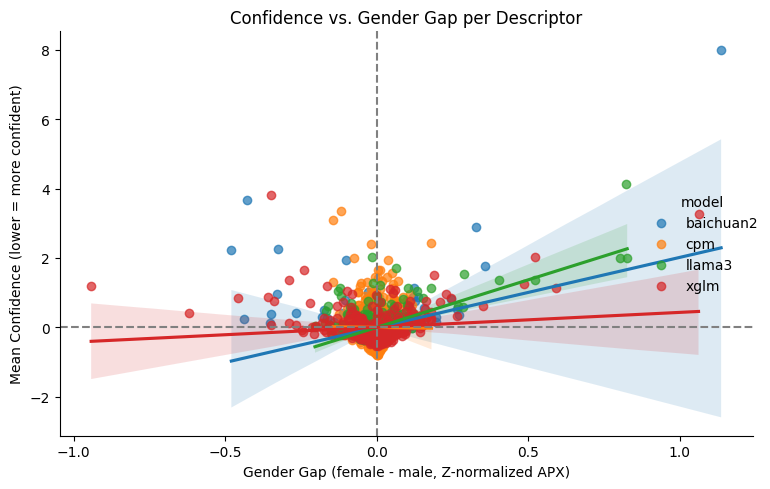

In [ ]:
#Confidence-Based Stereotyping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load files and calculate z-normalized APX_1, APX_2, APX_3
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []

for model, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model

    for apx_col in ['apx_1', 'apx_2', 'apx_3']:
        norm_col = f'{apx_col}_z'
        df[norm_col] = (df[apx_col] - df[apx_col].mean()) / df[apx_col].std()

    df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Step 2: Compute gender gap per descriptor per model
df_all['apx_mean_z'] = df_all[['apx_1_z', 'apx_2_z', 'apx_3_z']].mean(axis=1)

desc_stats = (
    df_all
    .groupby(['model', 'descriptor', 'gender'])['apx_mean_z']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean_z')
    .dropna()
    .reset_index()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['confidence'] = desc_stats[['female', 'male']].mean(axis=1)

# Step 3: Plot ‚Äî is stronger bias associated with higher confidence?
g = sns.lmplot(
    data=desc_stats,
    x='gap',
    y='confidence',
    hue='model',
    height=5,
    aspect=1.3,
    markers='o',
    scatter_kws={'alpha':0.7}
)
g.set_axis_labels("Gender Gap (female - male, Z-normalized APX)", "Mean Confidence (lower = more confident)")
plt.title("Confidence vs. Gender Gap per Descriptor")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

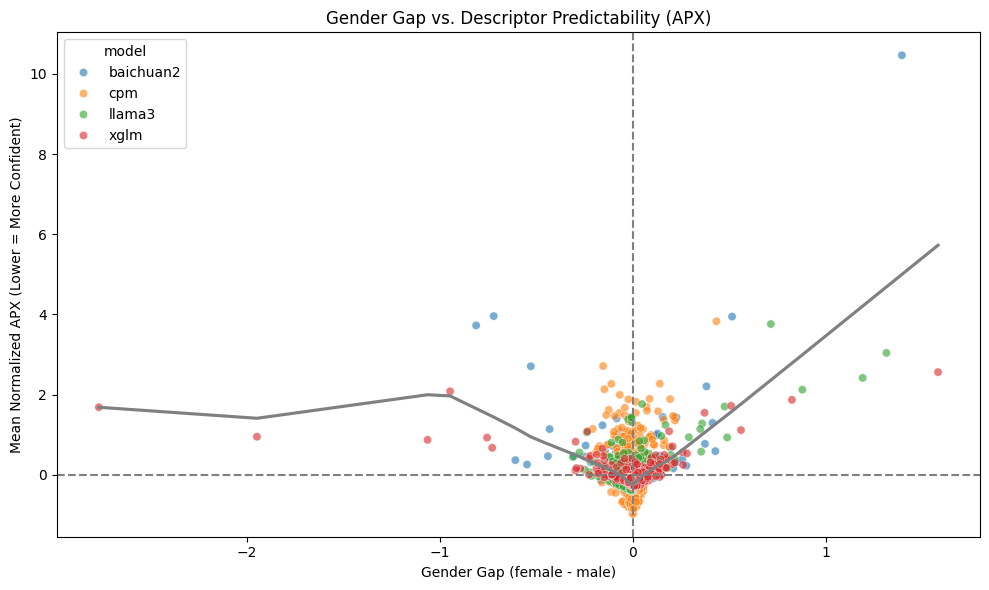

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Normalize APX mean within each model
df_all['apx_norm'] = df_all.groupby('model')['apx_mean'].transform(lambda x: (x - x.mean()) / x.std())

# Calculate descriptor-level gender gap and average APX per model
desc_gap = df_all.groupby(['model', 'descriptor', 'gender'])['apx_norm'].mean().reset_index()
pivot = desc_gap.pivot(index=['model', 'descriptor'], columns='gender', values='apx_norm').dropna()
pivot['gap'] = pivot['female'] - pivot['male']
pivot = pivot.reset_index()

# Merge back mean APX for confidence
mean_apx = df_all.groupby(['model', 'descriptor'])['apx_norm'].mean().reset_index()
merged = pd.merge(pivot, mean_apx, on=['model', 'descriptor'], how='left')

# Plot: Gender Gap vs Predictability (APX)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='gap', y='apx_norm', hue='model', alpha=0.6)
sns.regplot(data=merged, x='gap', y='apx_norm', scatter=False, color='gray', lowess=True)

plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Gender Gap vs. Descriptor Predictability (APX)')
plt.xlabel('Gender Gap (female - male)')
plt.ylabel('Mean Normalized APX (Lower = More Confident)')
plt.tight_layout()
plt.show()


<ipython-input-8-22c978c07951>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)
<ipython-input-8-22c978c07951>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_labeled.groupby(['model', 'axis', 'tier'])


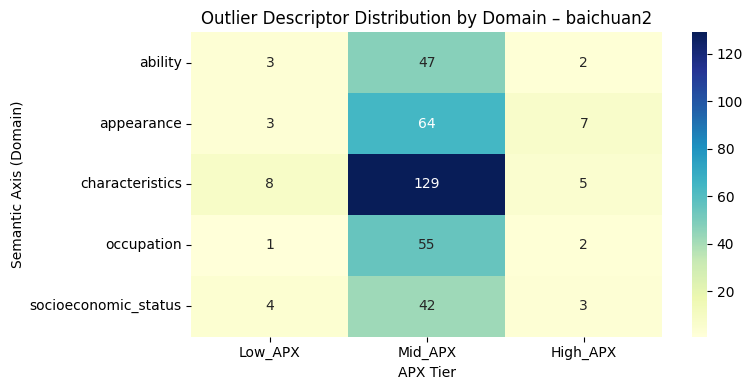

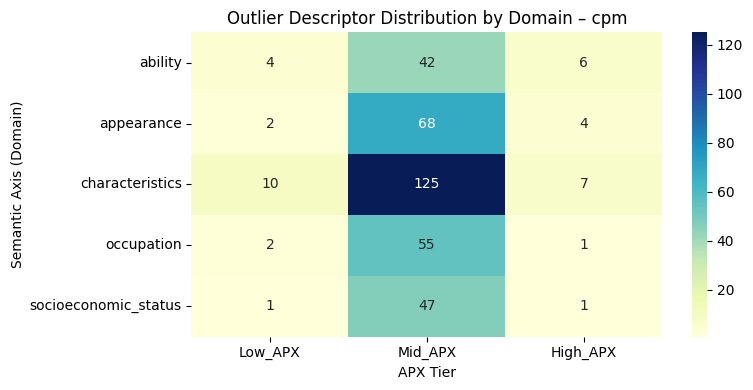

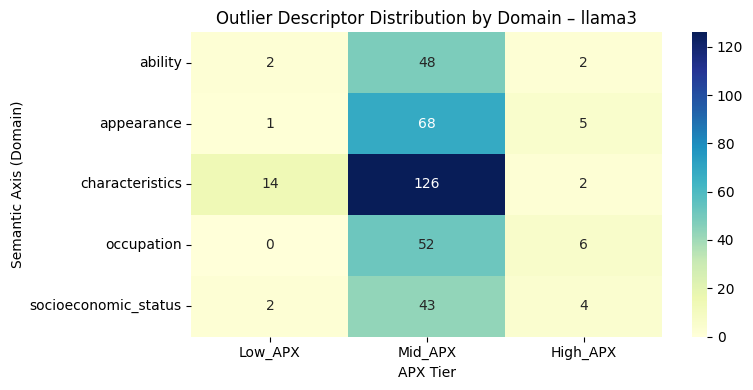

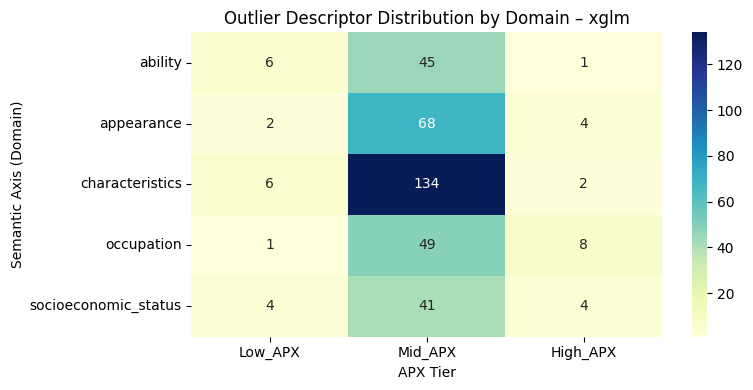

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess (same as previous steps)
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Step 1: Compute average APX per descriptor per model
desc_avg_apx = df_all.groupby(['model', 'descriptor', 'axis'])['apx_mean'].mean().reset_index()

# Step 2: Identify top 5% and bottom 5% descriptors per model
def label_apx_tier(subdf):
    lower = subdf['apx_mean'].quantile(0.05)
    upper = subdf['apx_mean'].quantile(0.95)
    subdf['tier'] = pd.cut(
        subdf['apx_mean'],
        bins=[-float('inf'), lower, upper, float('inf')],
        labels=['Low_APX', 'Mid_APX', 'High_APX']
    )
    return subdf

desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)

# Step 3: Pivot for heatmap: how many descriptors in each domain (axis) per tier
heatmap_data = (
    desc_labeled.groupby(['model', 'axis', 'tier'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 4: Plot heatmap per model
for model in heatmap_data['model'].unique():
    subset = heatmap_data[heatmap_data['model'] == model].set_index('axis')
    subset = subset[['Low_APX', 'Mid_APX', 'High_APX']]

    plt.figure(figsize=(8, 4))
    sns.heatmap(subset, annot=True, cmap='YlGnBu', fmt='d')
    plt.title(f'Outlier Descriptor Distribution by Domain ‚Äì {model}')
    plt.xlabel('APX Tier')
    plt.ylabel('Semantic Axis (Domain)')
    plt.tight_layout()
    plt.show()


<ipython-input-9-670db1a16cd3>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')


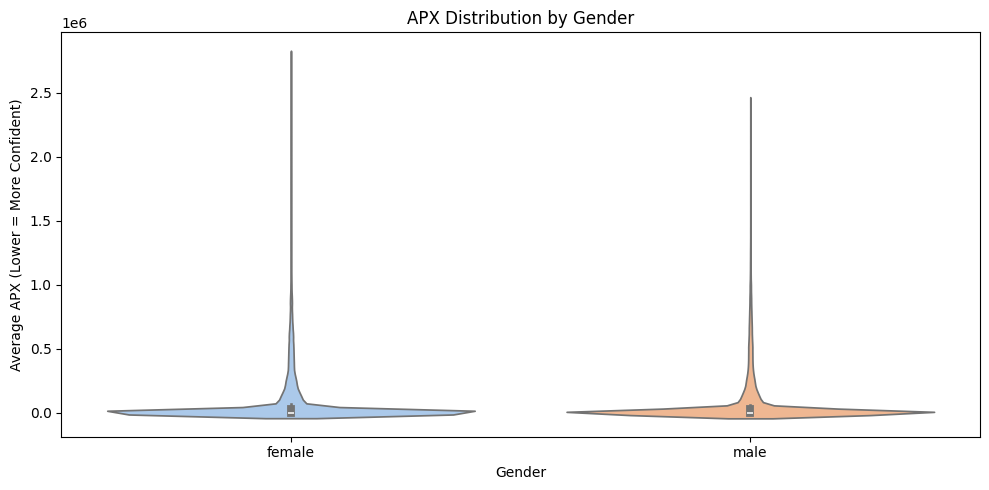

Wilcoxon test statistic = 555112.0000, p-value = 0.6436


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Drop NaNs
df_all = df_all.dropna(subset=['apx_mean', 'gender'])

# Step 1: Plot distribution by gender
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')
plt.title('APX Distribution by Gender')
plt.ylabel('Average APX (Lower = More Confident)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

# Step 2: Statistical test: Wilcoxon Signed-Rank Test (paired by descriptor + model)
# First, pivot to align male/female APX per descriptor
paired = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
)

# Wilcoxon test
stat, p = wilcoxon(paired['female'], paired['male'])
print(f"Wilcoxon test statistic = {stat:.4f}, p-value = {p:.4f}")


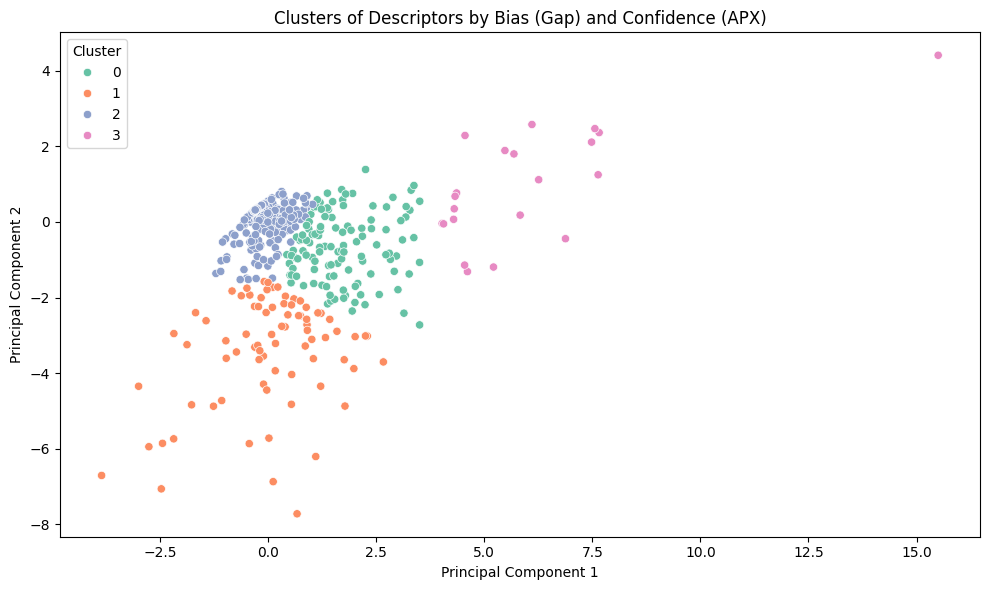


üîπ Cluster 0 ‚Äî Sample Descriptors:
- [cpm] Âª∫Á≠ëÂ∑•‰∫∫
- [cpm] ‰∏ìÊ®™
- [cpm] ÊìÖÈïøËøêÂä®
- [cpm] ÂπΩÈªò
- [cpm] ‰ºöË°®Ëææ
- [cpm] ËÄÅÊùø
- [cpm] Áõ≤‰∫∫
- [cpm] Ë†¢Á¨®
- [cpm] Â∑•‰∫∫Èò∂Á∫ß
- [cpm] ‰ΩìÊ†ºÂÅ•Â£Æ
- [cpm] Â∏∏Ê∏ÖÊ¥Å
- [cpm] Â§ß‰ºóËÑ∏
- [cpm] Ë°£ÂÜ†Ê•öÊ•ö
- [cpm] Ë¥üÂÄ∫ËÄÖ
- [cpm] ÂçïÁ∫Ø
- [baichuan2] È´ò
- [cpm] Êú∫Ê¢∞Â∏à
- [cpm] È°∫‰ªé
- [cpm] ÁßëÂ≠¶ÂÆ∂
- [cpm] ËÆ∞ËÄÖ

üîπ Cluster 1 ‚Äî Sample Descriptors:
- [cpm] ÊãúÈáë
- [cpm] ‰∏Ä‰∏ù‰∏çËãü
- [cpm] ÊìÖÈïøÈïøË∑ë
- [cpm] ÂåñÂ¶ÜÂ∏à
- [cpm] Âä®‰∫∫
- [cpm] È™ÑÂÇ≤
- [cpm] ÊÄßÊÑü
- [cpm] ‰æùËµñËΩÆÊ§Ö
- [cpm] Áà±Áæé
- [cpm] ËôöÂº±
- [cpm] ËÅ™Êòé
- [cpm] Â®áÂ™ö
- [cpm] Ë∫´ÊùêÂ∞èÂ∑ß
- [cpm] Á©øÁùÄÂçé‰∏Ω
- [cpm] ÂñÑ‰∫éÂÄæÂê¨
- [cpm] Ê∏©Âíå
- [cpm] ÊàòÂ£´
- [cpm] ÁªÜÂøÉ
- [cpm] ÂÖ≥ÂøÉÊîøÊ≤ª
- [cpm] ‰øùÂßÜ

üîπ Cluster 2 ‚Äî Sample Descriptors:
- [xglm] Ë¥´Á©∑
- [baichuan2] Ë¥§ÊÉ†
- [xglm] Â•áËë©
- [cpm] Â§öÊÑÅÂñÑÊÑü
- [xglm] ËÑ∏ÁöÆËñÑ
- [llama3] Ë¢´Êî∂ÂÖªÁöÑ‰∫∫
- [baichuan2] Áõ∏Ë≤åÂπ≥Âπ≥
- [llama3] ËÆ∞ËÄÖ
- [baichuan2] Ëá™Âç

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

# 1. Prepare data: Gender gap & APX mean per descriptor per model
df_all['apx_mean'] = df_all[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Pivot to get male/female APX side by side
pivot = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
    .reset_index()
)

pivot['gap'] = pivot['female'] - pivot['male']
pivot['mean_apx'] = pivot[['female', 'male']].mean(axis=1)

# 2. Standardize features
features = pivot[['gap', 'mean_apx']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Clustering (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
pivot['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Optional: Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pivot['PC1'] = X_pca[:, 0]
pivot['PC2'] = X_pca[:, 1]

# 5. Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters of Descriptors by Bias (Gap) and Confidence (APX)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

for cluster_id in sorted(pivot['cluster'].unique()):
    print(f"\nüîπ Cluster {cluster_id} ‚Äî Sample Descriptors:")
    sample = pivot[pivot['cluster'] == cluster_id].sample(20, random_state=42)
    for _, row in sample.iterrows():
        print(f"- [{row['model']}] {row['descriptor']}")

pivot[['model', 'descriptor', 'gap', 'mean_apx', 'cluster']].to_csv('descriptor_clusters.csv', index=False)


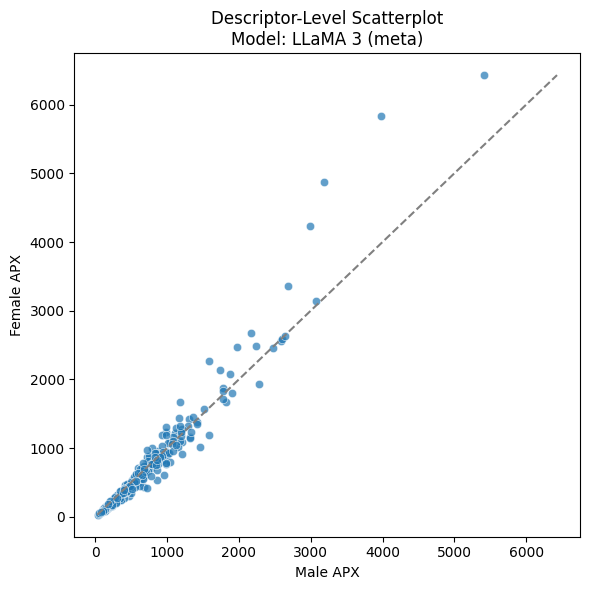

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: LLaMA 3 (meta)")
plt.tight_layout()
plt.show()


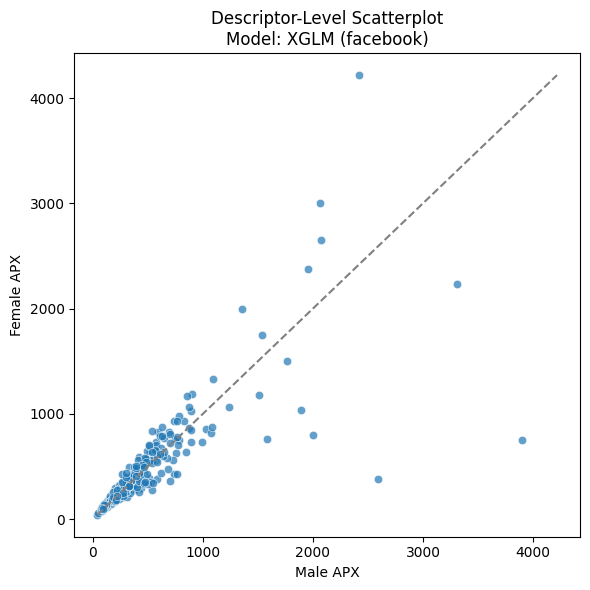

In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: XGLM (facebook)")
plt.tight_layout()
plt.show()


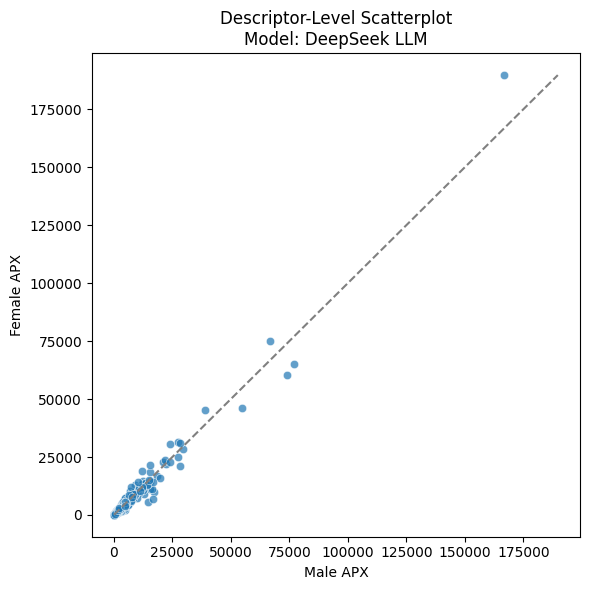

In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: DeepSeek LLM")
plt.tight_layout()
plt.show()


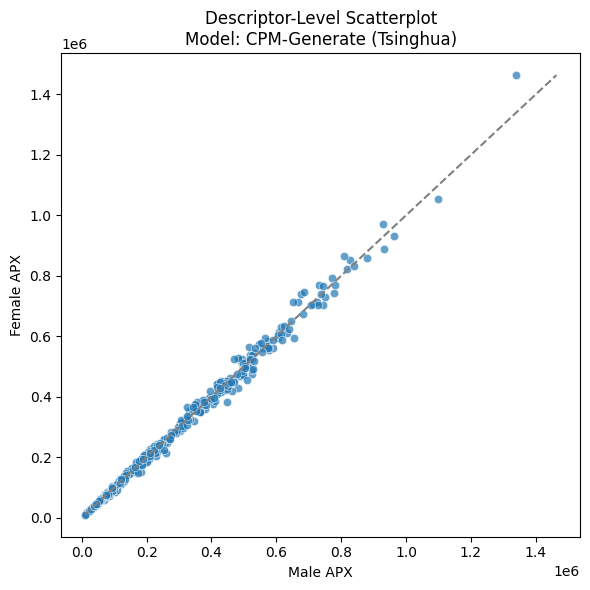

In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: CPM-Generate (Tsinghua)")
plt.tight_layout()
plt.show()


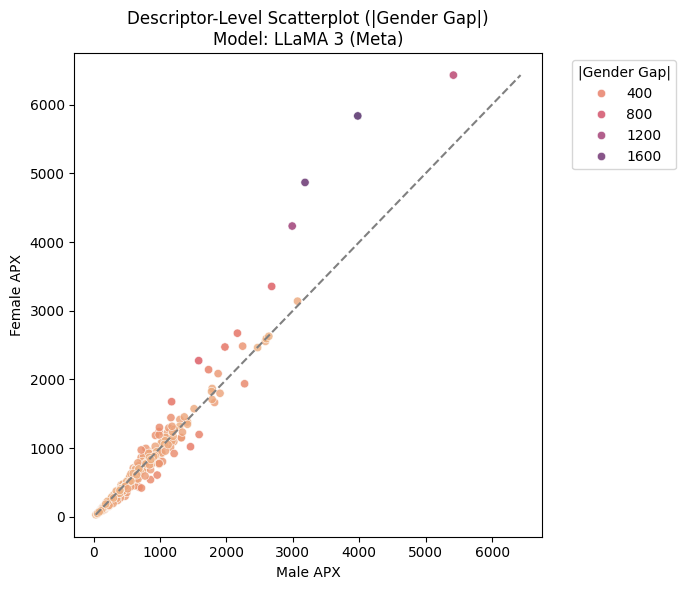

Top 10 descriptors with largest gender gap (LLaMA 3):
gender           female         male          gap      gap_abs
descriptor                                                    
ÊôÆÈÄö          5835.314360  3977.583792  1857.730568  1857.730568
Ë≠¶ÂØü          4867.317846  3183.336106  1683.981739  1683.981739
È¢ÜÂØº          4232.574365  2990.246735  1242.327630  1242.327630
Êó©ÊïôÂ∏à         6429.223607  5417.801536  1011.422071  1011.422071
Èáç           2273.309394  1581.949674   691.359720   691.359720
ËÄÅÂ∏à          3353.586596  2681.107641   672.478955   672.478955
ÂÅ•Â∫∑          2672.996372  2165.201558   507.794814   507.794814
Êú∫Ê¢∞Â∏à         1675.885586  1174.410192   501.475394   501.475394
Èõ∂Â∑•          2472.059813  1977.473975   494.585838   494.585838
Ë¶ÅÈ•øÊ≠ª         1020.835009  1459.052176  -438.217167   438.217167


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: LLaMA 3 (Meta)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (LLaMA 3):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


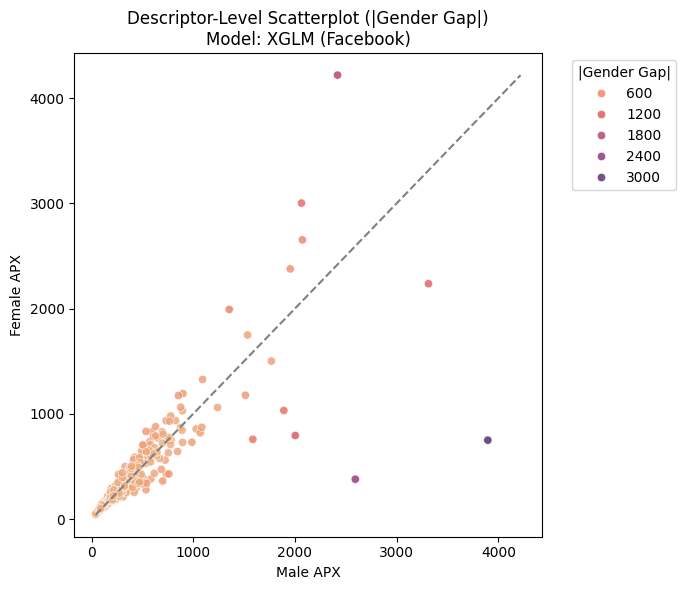

Top 10 descriptors with largest gender gap (XGLM):
gender           female         male          gap      gap_abs
descriptor                                                    
Ë≠¶ÂØü           749.494403  3896.735550 -3147.241148  3147.241148
Êñá‰∫∫           378.419739  2593.747126 -2215.327387  2215.327387
‰∏çËÇ≤          4218.606751  2419.023468  1799.583283  1799.583283
‰ΩúÂÆ∂           793.777132  2003.437920 -1209.660788  1209.660788
ÂçäËÅåÂ∑•         2236.376092  3313.065853 -1076.689761  1076.689761
‰∏çÂç´Áîü         3002.457770  2064.087121   938.370649   938.370649
Âè∏Êú∫          1031.802947  1890.859296  -859.056349   859.056349
ËÆ∞ËÄÖ           757.496962  1586.149219  -828.652256   828.652256
‰∏çÂÆâÂÖ®         1991.816318  1353.908277   637.908041   637.908041
Èáç           2652.949208  2073.047416   579.901792   579.901792


In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: XGLM (Facebook)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (XGLM):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


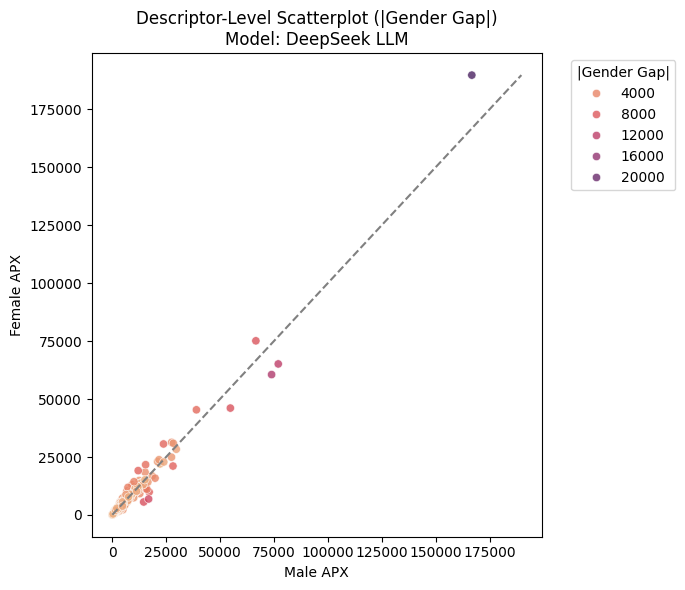

Top 10 descriptors with largest gender gap (DeepSeek):
gender             female           male           gap       gap_abs
descriptor                                                          
È´ò           189729.154772  166752.272673  22976.882099  22976.882099
Èáç            60557.387238   73929.966164 -13372.578926  13372.578926
ÂøóÊÑøËÄÖ          65147.000525   77015.834742 -11868.834217  11868.834217
Áæé‰∏Ω            6892.014198   16915.742775 -10023.728577  10023.728577
ÊºÇ‰∫Æ            5602.723429   14629.566302  -9026.842873   9026.842873
Ë∫´‰ΩìÂÅ•Â∫∑         46107.907206   54811.193762  -8703.286556   8703.286556
‰∏ªÂØº           75115.461381   66637.854376   8477.607005   8477.607005
‰∏∞Êª°            9916.284419   17164.586535  -7248.302115   7248.302115
Êä§Â£´           21106.178089   28205.280243  -7099.102154   7099.102154
ÁüÆ            19128.062498   12078.204600   7049.857898   7049.857898


In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: DeepSeek LLM")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (DeepSeek):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


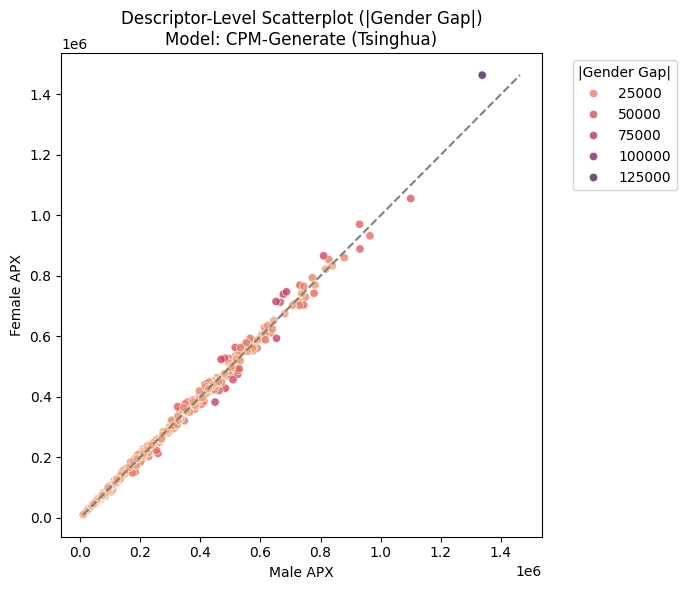

Top 10 descriptors with largest gender gap (CPM):
gender            female          male            gap        gap_abs
descriptor                                                          
ÂÖçÁñ´Á≥ªÁªüÂèóÊçü      1.464069e+06  1.338391e+06  125677.635185  125677.635185
Â®áÂ∞è          3.823621e+05  4.490206e+05  -66658.558625   66658.558625
ËÇåËÇâÂèëËææ        7.150437e+05  6.517478e+05   63295.904696   63295.904696
Âê∏ÊØíÊàêÁòæ        7.393502e+05  6.760967e+05   63253.491952   63253.491952
ËøëËßÜ          7.472322e+05  6.866734e+05   60558.760328   60558.760328
ÁªÜÂøÉ          5.931900e+05  6.533703e+05  -60180.294123   60180.294123
Áò´Áó™          8.664080e+05  8.103487e+05   56059.296815   56059.296815
ÊüîÂº±          4.281416e+05  4.830954e+05  -54953.856125   54953.856125
Ëã±‰øä          5.235896e+05  4.687967e+05   54792.886769   54792.886769
Ê∏ÖÁ∫Ø          4.563475e+05  5.087492e+05  -52401.763772   52401.763772


In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: CPM-Generate (Tsinghua)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (CPM):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


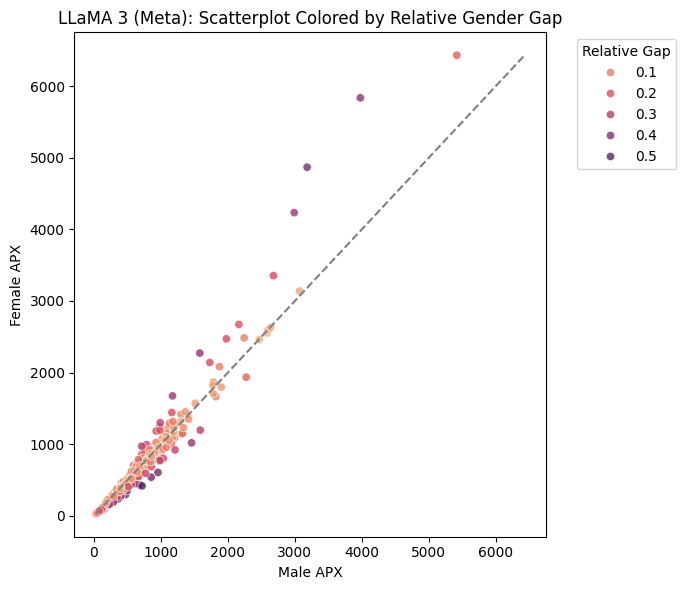

Top 10 Relative Gender Gaps ‚Äî LLaMA 3 (Meta):
gender           female         male  relative_gap
descriptor                                        
Áæé‰∏Ω           419.666913   720.338472      0.527491
‰∏∞Êª°           540.999947   856.449253      0.451464
Â¶ñÂ®Ü           300.421164   474.908406      0.450098
‰øè‰∏Ω           432.876159   683.323171      0.448750
Ê∏ÖÁ∫Ø           607.792779   957.575423      0.446901
Â∏∏Á©øËø∑‰Ω†Ë£ô        106.696300   166.979161      0.440543
Ë≠¶ÂØü          4867.317846  3183.336106      0.418347
Á∫§ÁªÜ           238.198391   360.146250      0.407617
Ë∫´ÊùêÂ∞èÂ∑ß         194.438529   293.647963      0.406524
Â®á‰øè           151.705413   228.262387      0.402966


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("LLaMA 3 (Meta): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps ‚Äî LLaMA 3 (Meta):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


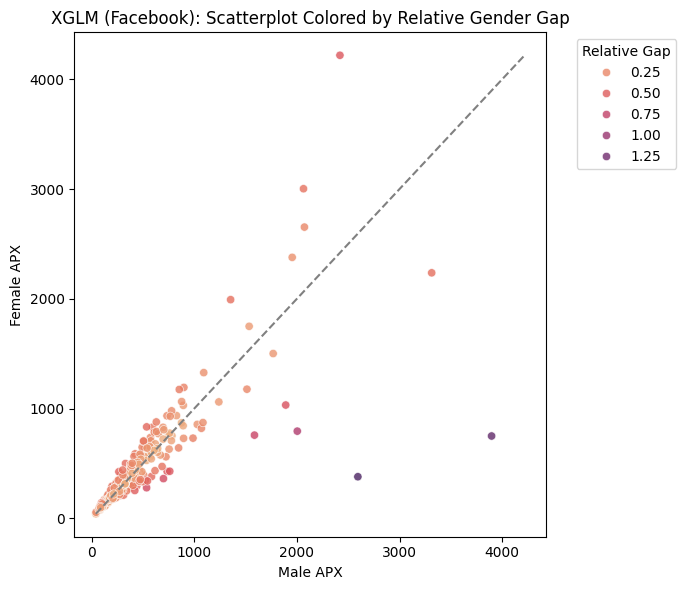

Top 10 Relative Gender Gaps ‚Äî XGLM (Facebook):
gender           female         male  relative_gap
descriptor                                        
Êñá‰∫∫           378.419739  2593.747126      1.490715
Ë≠¶ÂØü           749.494403  3896.735550      1.354750
‰ΩúÂÆ∂           793.777132  2003.437920      0.864904
ËÆ∞ËÄÖ           757.496962  1586.149219      0.707148
ÊùëÊ∞ë           361.301363   699.434249      0.637544
‰øùÂßÜ           278.098929   535.320633      0.632445
Âè∏Êú∫          1031.802947  1890.859296      0.587859
Áæé‰∏Ω           428.401611   760.939347      0.559197
‰∏çËÇ≤          4218.606751  2419.023468      0.542237
Â§ßÂ≠¶ÊØï‰∏öÁîü        427.155270   735.450303      0.530352


In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("XGLM (Facebook): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps ‚Äî XGLM (Facebook):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


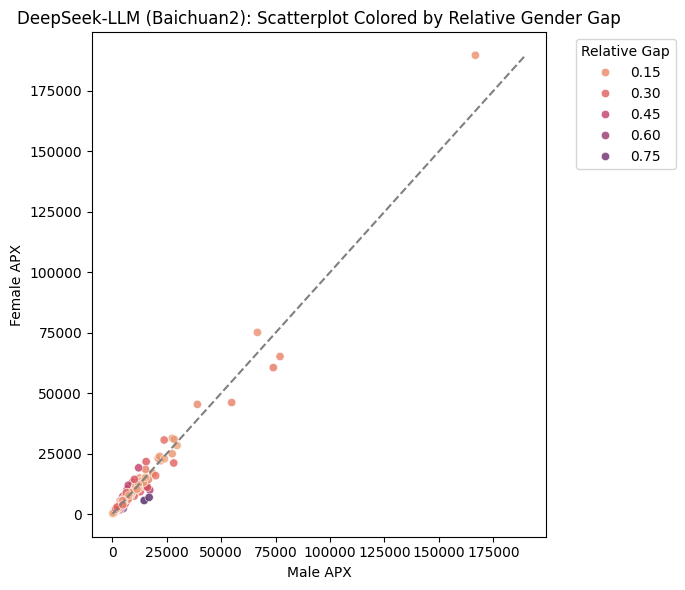

Top 10 Relative Gender Gaps ‚Äî DeepSeek (Baichuan2):
gender           female          male  relative_gap
descriptor                                         
ÊºÇ‰∫Æ          5602.723429  14629.566302      0.892320
Áæé‰∏Ω          6892.014198  16915.742775      0.842056
‰øè‰∏Ω          2252.277207   4964.358255      0.751619
Â®áÂ™ö          1733.397379   3373.874403      0.642408
ÂÆ∂Â∫≠‰∏ªÂ¶á         205.363678    383.550589      0.605137
Ë¥§Ê∑ë          1700.033625   3087.330319      0.579566
‰∏∞Êª°          9916.284419  17164.586535      0.535308
Ëã±‰øä          1516.345794    885.961957      0.524815
Â®á‰øè          1907.879393   3229.002210      0.514368
Â®¥ÈõÖ          2471.754377   4154.282923      0.507854


In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("DeepSeek-LLM (Baichuan2): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps ‚Äî DeepSeek (Baichuan2):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


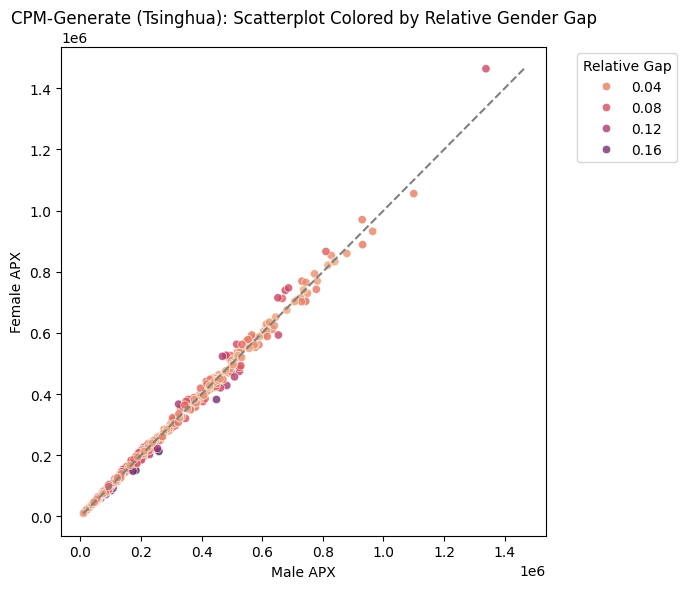

Top 10 Relative Gender Gaps ‚Äî CPM-Generate (Tsinghua):
gender             female           male  relative_gap
descriptor                                            
Á∫§ÁªÜ          212706.892361  259069.075865      0.196543
Â®áÂ™ö          150594.139085  183006.537301      0.194319
Â®á‰øè           84917.114213  101156.155228      0.174545
Â®áÂ∞è          382362.086248  449020.644873      0.160356
Á∫§Âº±          147945.445621  173700.835851      0.160147
Ê∏©Â©â           71909.714162   84239.405366      0.157922
Ê∏©È°∫           92241.252845  107435.407521      0.152188
Áæé‰∏Ω          222146.986314  254497.112723      0.135741
ÈÖ∑           367263.941216  324082.105593      0.124921
Â®áÁîüÊÉØÂÖª         59920.529169   67703.699271      0.121970


In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("CPM-Generate (Tsinghua): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps ‚Äî CPM-Generate (Tsinghua):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])
